# Bengali Fake News Classification


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install bnlp_toolkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import time

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm.notebook import tqdm
from transformers import BertModel, BertTokenizer, BertForSequenceClassification

In [ ]:
class NewsDatasets(Dataset):
    def __init__(self, data, max_length=100):
        self.data = data
        
        self.config = {
            "max_length": max_length,
            "padding": "max_length",
            "return_tensors": "pt",
            "truncation": True,
            "add_special_tokens": True
        }

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        value = self.data.iloc[idx]
        return value['head']+"[SEP]"+value['con'] , value['label']

In [ ]:
from sklearn.model_selection import train_test_split

auth = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Authentic-48K.csv")
fake = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Fake-1K.csv")
df = auth[:fake.shape[0]* 15]

df = df.append(fake)


train_df, test_df = train_test_split(df, test_size=0.1, random_state=121, stratify=df['label'])


df = train_df.append(train_df[train_df['label']==0].sample(len(fake)*14, replace=True))
df = df.sample(frac=1).reset_index(drop=True)
len(df) , len(auth)
train_df=df

In [ ]:
len(train_df)

36891

In [ ]:
train_df[train_df['label']==0].head()

,articleID,domain,date,category,headline,content,label
3,153,bd-pratidin.com,2019-08-29 19:51:12,Entertainment,'মাসুদ রানা' সিনেমার নায়িকা শ্রদ্ধা কাপুর,বাংলাদেশের জনপ্রিয় কথাসাহিত্যিক কাজী আনোয়ার ...,0
4,1069,motikontho.wordpress.com,2014-09-20T14:42:06+00:00,Miscellaneous,সারদা গ্রুপের টেকাটুকার বখরা না পাওয়ার প্রতিবা...,নিজস্ব মতিবেদকবাংলাদেশে পাচার করা ভারতের বাটপা...,0
6,281,bengalbeats.com,2019-06-13T16:39:26+00:00,National,কিশোরগঞ্জের রাস্তার মাঝে বৈদ্যুতিক খাম্বার সদ্...,আমরা সব কিছুই যদি নেতিবাচকভাবে নিতে থাকি তাহলে...,0
11,1021,channeldhaka.news,2019-02-27T16:59:50+00:00,International,একসাথে থাকতে চেয়ে হাইকোর্টে আবেদন ২ লেসবিয়ান...,ShareTweetপরিবারকে না জানিয়ে গত বছরই তারা বিয...,0
12,1294,bengalbeats.com,2019-06-20T13:00:00+00:00,Miscellaneous,লোহার খনিতে কি থাকে জিজ্ঞেস করে থাপ্পড় খেলেন এ...,সম্প্রতি বাংলাদেশে একটি লোহার খনি আবিষ্কার হয়ে...,0


In [ ]:
df.head()

,articleID,domain,date,category,headline,content,label
0,13098,bd24live.com,2018-09-24 13:41:37,National,"‘বন্দুকযুদ্ধে’ মাদককারবারি নিহত ২৪ সেপ্টেম্বর,...",সাভারে র‌্যাবের সঙ্গে বন্দুকযুদ্ধে আশাদুল (৩০)...,1
1,3584,kalerkantho.com,2018-09-20 17:50:58,National,কয়েকটি জেলার বন্যা পরিস্থিতির উন্নতি,"আগামী ২৪ ঘণ্টায় গাইবান্ধা, বগুড়া, সিরাজগঞ্জ, জ...",1
2,1866,mzamin.com,2018-09-20 21:28:44,National,সৌদি থেকে ফিরে আসা নারীদের মুখে লোমহর্ষক বর্ণনা,হাতে হলুদ রঙের একটি ছোট পলিথিন ব্যাগ।এরমধ্যে এ...,1
3,153,bd-pratidin.com,2019-08-29 19:51:12,Entertainment,'মাসুদ রানা' সিনেমার নায়িকা শ্রদ্ধা কাপুর,বাংলাদেশের জনপ্রিয় কথাসাহিত্যিক কাজী আনোয়ার ...,0
4,1069,motikontho.wordpress.com,2014-09-20T14:42:06+00:00,Miscellaneous,সারদা গ্রুপের টেকাটুকার বখরা না পাওয়ার প্রতিবা...,নিজস্ব মতিবেদকবাংলাদেশে পাচার করা ভারতের বাটপা...,0


In [ ]:
from bnlp import BasicTokenizer
from bnlp.corpus import stopwords, punctuations, letters, digits
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()


btokenizer = BasicTokenizer()

def clean_text(text):
    tokens = btokenizer.tokenize(text)
    filtered = []
    for i in tokens:
        i= ps.stem(i)
        if i in stopwords:
            continue
    
        if i in punctuations + '‘' + '’':
            continue
    
        filtered.append(i)
    
    return " ".join(filtered)

print("********** Before ***************")
text = train_df.iloc[1]['content']
print(text)
print("\n********** After ***************")
print(clean_text(text))

********** Before ***************
আগামী ২৪ ঘণ্টায় গাইবান্ধা, বগুড়া, সিরাজগঞ্জ, জামালপুর ও টাঙ্গাইল জেলার বন্যা পরিস্থিতির উন্নতি হতে পারে। আজ বন্যা পূর্বাভাস ও সতর্কীকরণ কেন্দ্রের এক সংবাদ বিজ্ঞপ্তিতে এ পূর্বাভাসের কথা জানানো হয়েছে। এতে বলা হয়, ব্রহ্মপুত্র ও গঙ্গা নদ-নদীর পানি সমতল হ্রাস পাচ্ছে যা পরবর্তী ৪৮ ঘণ্টা অব্যাহত থাকতে পারে। যমুনা ও পদ্মা নদীসমূহের পানি সমতল স্থিতিশীল আছে যা পরবর্তী ২৪ ঘণ্টায় হ্রাস পেতে পারে। অপরদিকে আপার মেঘনা অববাহিকার প্রধান নদীসমূহের পানি সমতল হ্রাস পাচ্ছে যা পরবর্তী ৪৮ ঘণ্টা পর্যন্ত অব্যাহত থাকতে পারে। পর্যবেক্ষণাধীন ৯৪টি পানি সমতল স্টেশনের মধ্যে ৩৪টি নদীর পানি বৃদ্ধি এবং ৫৫টি নদীর পানি হ্রাস পেয়েছে। গত ২৪ ঘণ্টায় দেশের জামালপুর স্টেশনে ৩৮ মিলিমিটার ( মি. মি.) বৃষ্টিপাত হয়েছে এবং রামগড় স্টেশনে বৃষ্টিপাতের পরিমাণ ছিল ৩১ মিলিমিটার (মি.মি.)।

********** After ***************
২৪ ঘণ্টায় গাইবান্ধা বগুড়া সিরাজগঞ্জ জামালপুর টাঙ্গাইল জেলার বন্যা পরিস্থিতির উন্নতি বন্যা পূর্বাভাস সতর্কীকরণ কেন্দ্রের এক সংবাদ বিজ্ঞপ্তিতে পূর্বাভাসের কথা হয়েছে ব্রহ্মপুত্র গঙ্গা নদ নদী

/usr/local/lib/python3.8/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [ ]:
train_df['head'] = train_df.headline.apply(clean_text)
train_df['con'] = train_df.content.apply(clean_text)
test_df['head'] = test_df.headline.apply(clean_text)
test_df['con'] = test_df.content.apply(clean_text)

from sklearn.model_selection import train_test_split

train_df, testa_df = train_test_split(df, test_size=0.2, random_state=121, stratify=df['label'])

In [ ]:
len(df), len(test_df)

(36891, 2079)

In [ ]:
training_data = NewsDatasets(train_df)
train_dataloader = DataLoader(training_data, batch_size=16, shuffle=True)

In [ ]:
test_data = NewsDatasets(test_df)
test_dataloader = DataLoader(test_data, batch_size=16, shuffle=True)

In [ ]:
class NewsBert(nn.Module):

    def __init__(self, bert):
        super(NewsBert, self).__init__()

        self.bert = bert

        # dropout layer
        self.dropout = nn.Dropout(0.2)

        # relu activation function
        self.relu = nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768, 256)
        # self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 256)
        self.fc4 = nn.Linear(256, 128)

        # dense layer 2 (Output layer)
        self.fc5 = nn.Linear(128, 2)  

    # define the forward pass
    def forward(self, input_ids, token_type_ids, attention_mask):
        # pass the inputs to the model
        out = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        x = self.fc1(out[1])
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(self.dropout(x))
        x = self.relu(x)
        x = self.fc4(self.dropout(x))
        x = self.relu(x)

        # output layer
        x = self.fc5(self.dropout(x))
        
        return x

In [ ]:
bert_model_name = "sagorsarker/bangla-bert-base"
bert = BertModel.from_pretrained(bert_model_name)
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

Some weights of the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# for param in bert.parameters():
#     param.requires_grad = False

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NewsBert(bert)
model.to(device);

In [ ]:
s = "আমি বাংলায় গান গাই। [SEP]"
t = tokenizer.encode_plus(s, return_tensors="pt").to(device)
print(t)
out = model(**t)
print(out)

{'input_ids': tensor([[  101,  2169,  2492,  9294,  2552, 13985,  1014,   102,   102]],
       device='cuda:0'), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}
tensor([[0.0792, 0.0458]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [ ]:
from torch.optim.lr_scheduler import StepLR

optimizer = AdamW(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

# Training

In [ ]:
def train(model, dataloader, optimizer, criterion, config):
    model.train()  # prep model for training
    train_loss = 0
    for batch in tqdm(dataloader):
        text, labels = batch

        model.zero_grad()

        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        logs = model(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss = criterion(logs, labels)
        train_loss += loss.item() * input_ids.size(0)
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

    return train_loss

In [ ]:
def evaluate(model, dataloader, criterion, config):
    total = 0
    correct = 0
    valid_loss = 0.0

    model.eval()  # prep model for evaluation
    for batch in dataloader:
        text, labels = batch
        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        output = model(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss_p = criterion(output, labels)
        # update running validation loss
        valid_loss += loss_p.item() * input_ids.size(0)
        # calculate accuracy
        proba = torch.exp(output)
        top_p, top_class = proba.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        # accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return total, correct, valid_loss

In [ ]:
epochs = 10
tokenizer_config = {
    "max_length": 100,
    "padding": "max_length",
    "return_tensors": "pt",
    "truncation": True,
    "add_special_tokens": True
}

In [ ]:
train_loss_data, valid_loss_data = [], []
valid_loss_min = np.Inf
since = time.time()
best_loss = np.inf

for epoch in range(epochs):
    print("Epoch: {}/{}".format(epoch + 1, epochs))
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    total = 0
    correct = 0
    e_since = time.time()

    # Train Model
    train_loss += train(model, train_dataloader, optimizer, criterion, tokenizer_config)
    # Now Evaluate
    out = evaluate(model, test_dataloader, criterion, tokenizer_config)
    total += out[0]
    correct += out[1]
    valid_loss += out[2]
    
    scheduler.step()

    # print training/validation statistics
    # calculate average loss over an epoch
    train_loss = train_loss / len(train_dataloader.dataset)
    valid_loss = valid_loss / len(test_dataloader.dataset)

    # calculate train loss and running loss
    train_loss_data.append(train_loss * 100)
    valid_loss_data.append(valid_loss * 100)
    
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model.state_dict(), "news_model1.pth")

    print("\tTrain loss:{:.6f}..".format(train_loss),
          "\tValid Loss:{:.6f}..".format(valid_loss),
          "\tAccuracy: {:.4f}".format(correct / total * 100))

time_elapsed = time.time() - since
print('Training completed in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

Epoch: 1/10


  0%|          | 0/2306 [00:00<?, ?it/s]

	Train loss:0.211189.. 	Valid Loss:0.178753.. 	Accuracy: 96.9697
Epoch: 2/10


  0%|          | 0/2306 [00:00<?, ?it/s]

	Train loss:0.032181.. 	Valid Loss:0.196520.. 	Accuracy: 97.3545
Epoch: 3/10


  0%|          | 0/2306 [00:00<?, ?it/s]

	Train loss:0.001763.. 	Valid Loss:0.212895.. 	Accuracy: 97.7393
Epoch: 4/10


  0%|          | 0/2306 [00:00<?, ?it/s]

	Train loss:0.001830.. 	Valid Loss:0.225043.. 	Accuracy: 97.8355
Epoch: 5/10


  0%|          | 0/2306 [00:00<?, ?it/s]

	Train loss:0.001027.. 	Valid Loss:0.228879.. 	Accuracy: 97.8355
Epoch: 6/10


  0%|          | 0/2306 [00:00<?, ?it/s]

	Train loss:0.000529.. 	Valid Loss:0.237315.. 	Accuracy: 97.8355
Epoch: 7/10


  0%|          | 0/2306 [00:00<?, ?it/s]

	Train loss:0.000803.. 	Valid Loss:0.237243.. 	Accuracy: 97.8836
Epoch: 8/10


  0%|          | 0/2306 [00:00<?, ?it/s]

	Train loss:0.001045.. 	Valid Loss:0.237217.. 	Accuracy: 97.8355
Epoch: 9/10


  0%|          | 0/2306 [00:00<?, ?it/s]

	Train loss:0.000573.. 	Valid Loss:0.237221.. 	Accuracy: 97.8355
Epoch: 10/10


  0%|          | 0/2306 [00:00<?, ?it/s]

	Train loss:0.000490.. 	Valid Loss:0.237250.. 	Accuracy: 97.8355
Training completed in 158m 33s


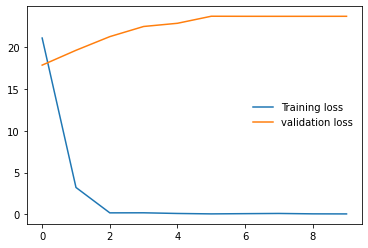

In [ ]:
from matplotlib import pyplot as plt

plt.plot(train_loss_data, label="Training loss")
plt.plot(valid_loss_data, label="validation loss")
plt.legend(frameon=False)

# Testing
To test this model, the left 15% data was used.

In [ ]:
model.load_state_dict(torch.load("./news_model1.pth", map_location = device))

<All keys matched successfully>

In [ ]:
all_preds = []
all_labels = []

for batch in test_dataloader:
    text, labels = batch
    inputs = tokenizer.batch_encode_plus(
        text, **tokenizer_config
    )
    input_ids = inputs['input_ids'].to(device)
    token_type_ids = inputs['token_type_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    labels = labels.to(device)

    # move things to model
    output = model(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)
    preds = output.detach().cpu().numpy()
    preds = np.argmax(preds, axis = 1)
    all_preds.extend(preds)
    all_labels.extend(labels.cpu().numpy())

In [ ]:
from sklearn.metrics import classification_report

# preds = np.argmax(preds, axis = 1)
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.76      0.75      0.76       130
           1       0.98      0.98      0.98      1949

    accuracy                           0.97      2079
   macro avg       0.87      0.87      0.87      2079
weighted avg       0.97      0.97      0.97      2079



#### Thank you very much for reading.
### পড়ার জন্য আপনাকে অনেক ধন্যবাদ।

In [ ]:
 from sklearn import metrics

In [ ]:
confusion_matrix = metrics.confusion_matrix(all_labels, all_preds)



In [ ]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])


In [ ]:
import matplotlib.pyplot as plt



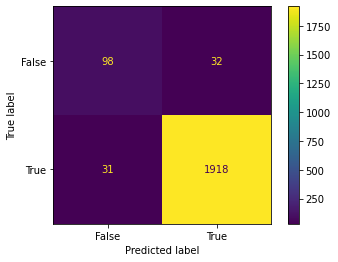

In [ ]:
cm_display.plot()
plt.show()